In [1]:
%pylab inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import numpy.random as rng
import pandas.io.data as web
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_prices(symbol):
    start, end = '2007-05-02', '2016-04-11'
    data = web.DataReader(symbol, 'yahoo', start, end)
    data=pd.DataFrame(data)
    prices=data['Adj Close']
    prices=prices.astype(float)
    return prices

def get_returns(prices):
        return ((prices-prices.shift(-1))/prices)[:-1]
    
def get_data(list):
    l = []
    for symbol in list:
        rets = get_returns(get_prices(symbol))
        l.append(rets)
    return np.array(l).T

def sort_data(rets):
    ins = []
    outs = []
    for i in range(len(rets)-100):
        ins.append(rets[i:i+100].tolist())
        outs.append(rets[i+100])
    return np.array(ins), np.array(outs)
        


In [3]:
symbol_list = ['C', 'GS']
rets = get_data(symbol_list)
ins, outs = sort_data(rets)
ins = ins.transpose([0,2,1]).reshape([-1, len(symbol_list) * 100])
div = int(.8 * ins.shape[0])
train_ins, train_outs = ins[:div], outs[:div]
test_ins, test_outs = ins[div:], outs[div:]

#normalize inputs
train_ins, test_ins = train_ins/np.std(ins), test_ins/np.std(ins)

In [4]:
sess = tf.InteractiveSession()

In [18]:
positions = tf.constant([-1,0,1]) 
num_positions = 3

x = tf.placeholder(tf.float32, [None, len(symbol_list) * 100])
y_ = tf.placeholder(tf.float32, [None,  len(symbol_list)])

W = tf.Variable(tf.random_normal([len(symbol_list) * 100, num_positions * len(symbol_list)]))
b = tf.Variable(tf.random_normal([num_positions * len(symbol_list)]))

y = tf.matmul(x, W) + b 


# loop through symbol, taking the columns for each symbol's bucket together
pos = {}
symbol_returns = {}
relevant_target_column = {}
for i in range(len(symbol_list)):
    # isolate the buckets relevant to the symbol and get a softmax as well
    symbol_probs = y[:,i*num_positions:(i+1)*num_positions]
    symbol_probs_softmax = tf.nn.softmax(symbol_probs) # softmax[i, j] = exp(logits[i, j]) / sum(exp(logits[i]))
    # sample probability to chose our policy's action
    sample = tf.multinomial(tf.log(symbol_probs_softmax), 1)#sample = tf.argmax(symbol_probs_softmax, 1) #use a real sample
    pos[i] = tf.reshape(sample, [-1]) - 1   # choose(-1,0,1)
    # get returns by multiplying the policy (position taken) by the target return for that day
    symbol_returns[i] = tf.mul(tf.cast(pos[i], float32),  y_[:,i])
    # isolate the probability of the selected policy (for use in calculating gradient)
    sample_mask = tf.reshape(tf.one_hot(sample, 3), [-1,3])
    relevant_target_column[i] = tf.reduce_sum(symbol_probs_softmax * sample_mask,1) # should be relevant to SAMPLE
    
# calculate the PERFORMANCE METRICS for the data chosen
daily_returns_by_symbol = tf.concat(1, [tf.reshape(t, [-1,1]) for t in symbol_returns.values()])
daily_returns = tf.reduce_sum(daily_returns_by_symbol,1)/2
total_return = tf.reduce_prod(daily_returns + 1)
ann_vol = tf.mul(
    tf.sqrt(tf.reduce_mean(tf.pow((daily_returns - tf.reduce_mean(daily_returns)),2))) ,
    np.sqrt(252)
    )
sharpe = total_return / ann_vol

# CROSS ENTROPY
training_target_cols = tf.concat(1, [tf.reshape(t, [-1,1]) for t in relevant_target_column.values()])
ones = tf.ones_like(training_target_cols)
gradient = tf.nn.sigmoid_cross_entropy_with_logits(training_target_cols, ones)

# COST
# how should we do this step? it depends how we want to group our results. Choose your own adventure here by uncommenting a cost fn
# this is the most obvious: we push each weight to what works or not. Try it out...we're gonna be RICH!!!! oh, wait...
#cost = tf.mul(gradient , daily_returns_by_symbol)
# this takes the overall daily return and pushes the weights so that the overall day wins. Again, it overfits enormously
#cost = tf.mul(gradient , tf.reshape(daily_returns,[-1,1]))
# this multiplies every gradient by the overall return. If the strategy won for the past ten years, we do more of it and vice versa
cost = tf.mul(gradient , total_return)
costfn = tf.reduce_mean(cost)

optimizer = tf.train.GradientDescentOptimizer(0.005).minimize(cost)

In [29]:
# initialize variables to random values
init = tf.initialize_all_variables()
sess.run(init)
# run optimizer on entire training data set many times
train_size = train_ins.shape[0]
for epoch in range(20000):
    start = rng.randint(train_size-50)
    batch_size = rng.randint(2,20)
    end = min(train_size, start+batch_size)
    
    sess.run(optimizer, feed_dict={x: train_ins[start:end], y_: train_outs[start:end]})#.reshape(1,-1).T})
    # every 1000 iterations record progress
    if (epoch+1)%5000== 0:
        c,t = sess.run([costfn, total_return], feed_dict={x: train_ins, y_: train_outs})#.reshape(1,-1).T})
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c), "total return=", "{:.9f}".format(t-1))

Epoch: 5000 cost= 0.173014879 total return= -0.486480296
Epoch: 10000 cost= 0.256526262 total return= -0.228146195
Epoch: 15000 cost= 0.159734488 total return= -0.520039856
Epoch: 20000 cost= 0.200976387 total return= -0.391009867


In [25]:
# in sample results
d, t = sess.run([daily_returns, gradient], feed_dict={x: train_ins, y_: train_outs})

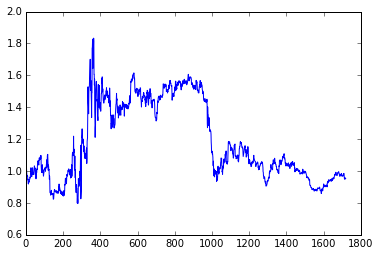

In [26]:
# equity curve
plot(np.cumprod(d+1))

In [27]:
#out of sample results
d, t = sess.run([daily_returns, gradient], feed_dict={x: test_ins, y_: test_outs})

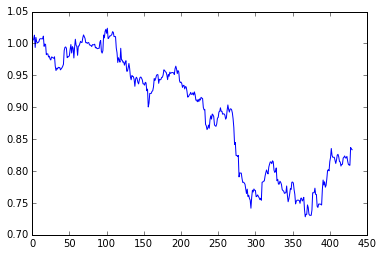

In [28]:
#out of sample results
plot(np.cumprod(d+1))